# Modelos Discriminativos - Parte 2 - Sistemas Não-Lineares

Os sistemas lineares têm a vantagem de serem facilmente treinados através de um processo de otimização convexa, isto é, que só tem um ponto de mínimo. Apesar disso, 

## Objetivos

Ao fim desta iteração, o aluno será capaz de:
* Entender o conceito e as limitações da propriedade *aproximação universal*
* Entender os algoritmos de *backpropagation*
* Aplicar redes MLP para problemas de classificação
* Configurar redes MLP quanto ao seu número de neurônios e número de camadas

In [83]:
# Inicializacao
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# Abrindo conjunto de dados
import csv
with open("biometria.csv", 'rb') as f:
    dados = list(csv.reader(f))
    
rotulos_volei = [d[0] for d in dados[1:-1] if d[0] is 'V']
rotulos_futebol = [d[0] for d in dados[1:-1] if d[0] is 'F']
altura_volei = [[float(d[1])] for d in dados[1:-1] if d[0] is 'V']
altura_futebol = [[float(d[1])] for d in dados[1:-1] if d[0] is 'F']
peso_volei = [[float(d[2])] for d in dados[1:-1] if d[0] is 'V']
peso_futebol = [[float(d[2])] for d in dados[1:-1] if d[0] is 'F']

## Erro de aproximação

Seja um sistema qualquer cuja saída é uma estimativa $\boldsymbol y_e$. Se comparada a uma referência $\boldsymbol y$, o erro quadrático médio (EQM) da aproximação será igual a

$$E = ||\boldsymbol y_e - \boldsymbol y||^2.$$

Podemos calcular a derivada da aproximação em relação ao erro (ou: o gradiente da aproximação em relação ao erro). O gradiente $\nabla E_{\boldsymbol y_e}$ é um vetor de mesma dimensão de $\boldsymbol y_e$ que indica a direção na qual o erro aumenta mais em relação à aproximação, dado por:

$$\nabla E_{\boldsymbol y_e} = 
\begin{pmatrix}
  \frac{dE}{d y_{e1}}  \\
  \frac{dE}{d y_{e2}} \\
   	\vdots \\
  \frac{dE}{d y_{eI}} 
 \end{pmatrix}
 = 
 \begin{pmatrix}
  2 (y_{e1} - y_1) \\
  2 (y_{e2} - y_2) \\
   	\vdots \\
  2 (y_{eI} - y_I) 
 \end{pmatrix} 
 =
 2 (\boldsymbol y_e - \boldsymbol y).$$

Esse resultado é importante porque um passo pequeno na direção contrária do gradiente levará à redução do erro. Assim, dado um fator multiplicativo $\alpha$, temos que $\boldsymbol y_e - \alpha \nabla E_{\boldsymbol y_e}$ é uma operação que reduz o EQM.

Ao realizar a operação:
$$\boldsymbol y_e \leftarrow \boldsymbol y_e - \alpha \frac{\nabla E_{\boldsymbol y_e}}{||\nabla E_{\boldsymbol y_e}||},$$
temos ainda a garantia de que a norma L2 do vetor que será somado a $\boldsymbol y_e$ tem norma conhecida.

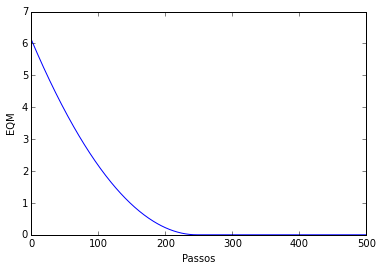

In [81]:
alpha = 0.01 # Tamanho do passo
y = np.array([1, 2., 1., 0., 0., -2., 0.5, .3]) # Referencia
y_e = np.random.random(y.shape) # Vetor inicial

n_passos = 500 # Vamos executar este numero de passos de otimizacao
eqm = np.zeros((n_passos + 1)) # Vetor que recebera o EQM a cada iteracao
eqm[0] = np.sum((y_e - y)**2)
for i in xrange(n_passos):
    gradiente = 2*(y_e - y)
    y_e -= alpha * gradiente / np.linalg.norm(gradiente)
    eqm[i + 1] = np.sum((y_e - y)**2)

plt.figure();
plt.plot(range(n_passos+1), eqm);
plt.ylabel('EQM');
plt.xlabel('Passos');


Fica claro que o programa construído, de fato, reduz o EQM. Apesar disso, a solução ótima é trivial: se sabemos o valor-objetivo $\boldsymbol y$ de $\boldsymbol y_e$, basta fazê-lo igual a este valor que o erro se tornará nulo.

O sistema é mais interessante caso $\boldsymbol y_e$ seja uma combinação linear de um vetor de entradas $\boldsymbol x$. Neste caso, temos:

$$\boldsymbol y_e = \boldsymbol A \boldsymbol x,$$

onde $\boldsymbol A$ é uma matriz de coeficientes de combinação. Temos liberdade para alterar $\boldsymbol A$, mas não  diretamente $\boldsymbol x$ ou $\boldsymbol y_e$. Para tal, vamos aplicar o mesmo processo de minimização por gradiente descendente:

$$\nabla E _{\boldsymbol A} = \frac{dE}{d \boldsymbol A} = \frac{dE}{d \boldsymbol y_e} \frac{d \boldsymbol y_e}{d \boldsymbol A} = 2 (\boldsymbol y_e - \boldsymbol y) \boldsymbol x^T.$$



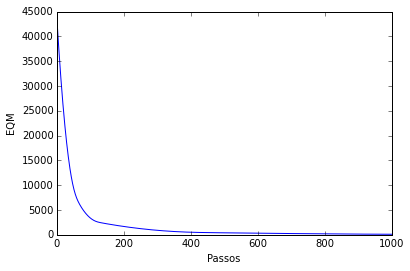

In [66]:
alpha = 0.01 # Tamanho do passo
x = np.array([[1, 50, 3],[5, 300, 2],[2, 3, 100]]) # Entradas de referencia
y = np.array([[3], [20], [-7]]) # Saidas de referencia
A = np.random.random((y.shape[0], x.shape[0]))
              
n_passos = 1000 # Vamos executar este numero de passos de otimizacao
eqm2 = np.zeros((n_passos+1)) # Vetor que recebera o EQM a cada iteracao
y_e = A * x
eqm2[0] = np.sum((y_e - y)**2)
for i in xrange(n_passos):
    gradiente = 2*(y_e - y) * x.T
    A -= alpha * gradiente / np.linalg.norm(gradiente)
    y_e = A * x
    eqm2[i+1] = np.sum((y_e - y)**2)

plt.figure();
plt.plot(range(n_passos+1), eqm2);
plt.ylabel('EQM');
plt.xlabel('Passos');

A restrição do formato da função ($\boldsymbol A \boldsymbol x$) pode implicar em nunca reduzir o EQM a zero. Isso não significa que aproximações lineares não sejam úteis: podemos usar esse processo para deduzir, por exemplo, o valor da aceleração gravitacional à partir de uma série de medições de tempo de queda de objetos à em diferentes alturas. Sistemas lineares podem ser, também, treinados usando o processo de pseudo-inversão visto anteriormente.



## Sistemas não-lineares

Um sistema não-linear é aquele que não obedece as condições de linearidade. De forma geral, ele pode ser escrito como um vetor de saídas $\boldsymbol y$ que é definido em função de um vetor de entradas $\boldsymbol x$:

$$\boldsymbol y_e = f(\boldsymbol A \boldsymbol x),$$

onde $\boldsymbol y$ e $\boldsymbol x$ são dados do problema e $\boldsymbol A$ é uma matriz que combina linearmente os elementos das entradas. Uma possível função $f(.)$ é a tangente hiperbólica, que resulta num sistema:



In [51]:
def nl_forward(A, x):
    return np.tanh(np.dot(A,x))

A = np.array([[-1, 0], [0, 1], [0.5, 0.5]]) # Entram dois elementos e saem três
x = np.array([[1, 0, 0.1, 0.3], [1, 0.1, 0, 10]]) # Entra Quatro vetores-coluna

print nl_forward(A, x)

[[-0.76159416  0.         -0.09966799 -0.29131261]
 [ 0.76159416  0.09966799  0.          1.        ]
 [ 0.76159416  0.04995837  0.04995837  0.99993274]]


Porém, lembremos: queremos que nossa função tenha um comportamento específico, e não um comportamento arbitrário e/ou aparentemente aleatório. Idealmente, gostaríamos que os pesos fossem ajustados de forma a reduzir o erro das saídas em relação a um conjunto de dados de treinamento. À partir disso, verificaremos como o comportamento de nossa função é generalizado, avaliando seu comportamento em dados de teste.

Podemos usar, novamente, a regra da cadeia para evidenciar uma expressão para o gradiente do erro em relação aos coeficientes da matriz $\boldsymbol A$:

$$\nabla E _\boldsymbol A = \frac{dE}{d \boldsymbol y_e} \frac{d \boldsymbol y_e}{d\boldsymbol A} = \frac{dE}{d \boldsymbol y_e} \frac{d \boldsymbol f(\boldsymbol A \boldsymbol x)}{d\boldsymbol A \boldsymbol x} \frac{d \boldsymbol A \boldsymbol x}{d \boldsymbol A}$$

e, portanto:

$$\nabla E _\boldsymbol A = (2 (y_e - y) \otimes f'(\boldsymbol A \boldsymbol x)) x^T,$$

onde $\otimes$ denota a multiplicação elemento-a-elemento.

Se fixarmos o formato da função $f(.)$, podemos executar, também, o processo de minimização por gradiente descendente:

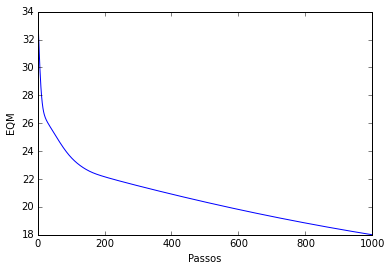

In [84]:
y = np.array([[1, 0, 2, 3], [0, 1, -1, 3], [1, 2, 1, 3]]) # Saem quatro vetores-coluna de três elementos cada
A = np.array([[-1, 0], [0, 1], [0.5, 0.5]]) # Entram dois elementos e saem três
x = np.array([[1, 0, 0.1, 0.3], [1, 0.1, 0, 10]]) # Entram quatro vetores-coluna de dois elementos cada

def gradiente(y, A, x):
    y_e = nl_forward(A, x)
    dedy = (y_e - y)
    return np.dot (dedy * (1-np.tanh(np.dot(A,x))**2) , x.T)

def erro(y, y_e):
    return np.sum((y-y_e)**2)


alpha = 0.01
n_passos = 1000 # Vamos executar este numero de passos de otimizacao
eqm3 = np.zeros((n_passos+1)) # Vetor que recebera o EQM a cada iteracao
eqm3[0] = erro(y, nl_forward(A, x)) 
for i in xrange(n_passos):
    eqm3[i+1] = erro(y, nl_forward(A, x))    
    g = gradiente(y, A, x)
    A -= alpha * g / np.linalg.norm(g)

plt.figure();
plt.plot(range(n_passos+1), eqm3);
plt.ylabel('EQM');
plt.xlabel('Passos');
    

## Sistema não linear com linearidade na saída

Vamos supor agora que o sistema não-linear recebeu uma nova operação de combinação linear na saída. Assim, temos:

$$ \boldsymbol y_e = \boldsymbol B f(\boldsymbol A \boldsymbol x).$$

Neste caso, temos duas matrizes de coeficientes que podem ser otimizadas, $\boldsymbol A$ e $\boldsymbol B$. Usando a regra da cadeia, podemos calcular ambos os gradientes:

$$\nabla E_{\boldsymbol A} = \frac{dE}{d \boldsymbol y_e} \frac{d \boldsymbol y_e}{d \boldsymbol A}
= \frac{dE}{d \boldsymbol y_e} \frac{d \boldsymbol y_e}{d \boldsymbol A \boldsymbol x} \frac{d \boldsymbol A \boldsymbol x}{d \boldsymbol A}
= (2(\boldsymbol y_e - \boldsymbol y) \otimes \boldsymbol B f'(\boldsymbol A \boldsymbol x) ) \boldsymbol x^T.
$$

$$\nabla E_{\boldsymbol B} = \frac{dE}{d \boldsymbol y_e} \frac{d \boldsymbol y_e}{d \boldsymbol B}
= 2(\boldsymbol y_e - \boldsymbol y) f^T(\boldsymbol A \boldsymbol x).
$$

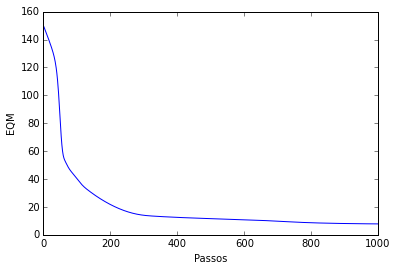

In [82]:
y = np.array([[1, 0, 2, 3], [0, 1, -1, 3], [1, 2, 1, 3]]).astype(float) # Saem quatro vetores-coluna de três elementos
A = np.array([[-1, 0], [0, 1], [0.5, 0.5]]).astype(float) # Entram dois elementos e saem três
B = np.array([[-1, 1, 2], [1, -1, 0], [-2, -3, -4]]).astype(float) # Entram tres elementos e saem tres
x = np.array([[1, 0, 0.1, 0.3], [1, 0.1, 0, 10]]).astype(float) # Entram quatro vetores-coluna de dois elementos

def nl_forward2(A, x, B):
    return np.dot(B, np.tanh(np.dot(A,x)))

def gradienteB(y, A, x, B):
    ye = nl_forward2(A, x, B)
    z = np.dot(A, x)
    dedy = ye - y
    return np.dot(dedy, np.tanh(z).T)

def gradienteA(y, A, x, B):
    y_e = nl_forward2(A, x, B)
    return np.dot((y_e - y) * np.dot(B, (1-np.tanh(np.dot(A,x))**2)), x.T)

def erro(y, y_e):
    return np.sum((y-y_e)**2)

alpha = 0.01
n_passos = 1000 # Vamos executar este numero de passos de otimizacao
eqm4 = np.zeros((n_passos+1)) # Vetor que recebera o EQM a cada iteracao
eqm4[0] = erro(y, nl_forward2(A, x, B)) 
for i in xrange(n_passos):
    eqm4[i+1] = erro(y, nl_forward2(A, x, B))    
    gA = gradienteA(y, A, x, B)
    gB = gradienteB(y, A, x, B)
    A -= alpha * gA / np.linalg.norm(gA)
    B -= alpha * gB / np.linalg.norm(gB)
    

plt.figure();
plt.plot(range(n_passos+1), eqm4);
plt.ylabel('EQM');
plt.xlabel('Passos');
    

## Discussões

### Não-linearidade
A não-linearidade do tipo tangente hiperbólica tem a característica de ser quase linear próxima a zero, mas saturar em valores $-1$ e $1$ para entradas de grande valor absoluto.


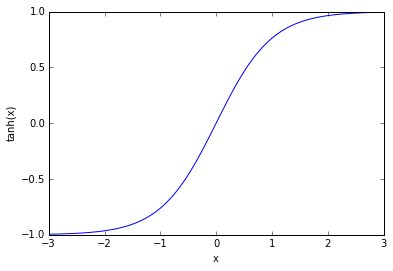

In [87]:
x = np.linspace(-3, 3, num=100)
plt.figure();
plt.plot(x, np.tanh(x));
plt.ylabel('tanh(x)');
plt.xlabel('x');

Trata-se, assim, de uma aproximação das funções de classificação tipo degrau, que valem $1$ para entradas positivas e $-1$ para entradas negativas. A vantagem da função tangente hiperbólica é que sua derivada é definida, o que permite a otimização de nossa estrutura pelo método de gradiente descendente.

### Redes Neurais MLP
A função se aproxima de um modelo de neurônio de acordo com o qual ele será ativado se sua entrada ultrapassar um determinado valor. Esse modelo é chamado de *perceptron*. Assim, cada unidade que calcula $tanh(x)$ é chamada de *perceptron*. É possível criar diversas camadas de *perceptrons* (expandindo a definição da função não linear, como em $\boldsymbol y_e = \boldsymbol B f(\boldsymbol A f(\boldsymbol C \boldsymbol x))$). Esses perceptrons estão organizados numa rede definida pelas matrizes de coeficientes. Assim, a estrutura com que temos trabalhado é uma rede de neurônios artificiais, ou ainda, uma *rede neural artificial*. Mais especificamente, esta é uma rede com perceptrons organizados em múltiplas camadas, e, por isso, é chamada de *multi-layer perceptron* (*MLP*).

### Aproximação Universal
Aa estrutura do tipo $\boldsymbol y_e = \boldsymbol B f(\boldsymbol A \boldsymbol x)$ temos duas etapas de combinações lineares e, entre elas, uma etapa não-linear. Com essa estrutura, é possível definir arbitrariamente qual será o número de unidades de funções não-lineares que serão aplicadas através da escolha do número de linhas de $\boldsymbol A$ e do número de colunas de $\boldsymbol B$.

O *Teorema da Aproximação Universal* mostra que, para qualquer função, existe um número de elementos não-lineares (nessa estrutura) que permite uma aproximação com erro arbitrariamente pequeno. Assim, é possível encontrar coeficientes adequados que levarão essa estrutura a convergir para qualquer função à partir de amostras, isto é, sem que a função seja conhecida. Essa propriedade é especialmente útil em situações em que não é possível deduzir uma função precisa, por exemplo:

* Prever o desempenho de um aluno na última prova de um curso à partir de seu desempenho nas demais avaliações,
* Definir se devemos comprar ou vender determinadas ações tomando por base seus valores passados,
* Escolher quais jogadores deverão participar de um time

Ao mesmo tempo, o *Teorema da Aproximação Universal* não leva em consideração a dificuldade inerente de encontrar os coeficientes corretos do sistema. Fazendo um paralelo com aproximações polinomiais, é possível imaginar que o número de amostras de dados necessárias para treinar uma estrutura como a que propusemos é, ao menos, proporcional ao número de coeficientes a serem determinados. A presença de coeficientes em excesso leva ao *sobre-ajuste* (*overfitting*), isto é, a função aproximará bem os dados de treino, mas falhará com relação aos dados de teste.

### Retropropagação do erro
O algoritmo de otimização por gradiente descendente, na forma que vimos, pode ser entendido à partir da retropropagação do erro de aproximação através das camadas da rede MLP. Para cada camada não-linear adicional, o gradiente do erro será dado pelos seguintes fatores:


